In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/kickstarter2018nlp/ks-projects-201801-extra.csv


In [2]:
%matplotlib inline

import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics

ks = pd.read_csv('../input/kickstarter2018nlp/ks-projects-201801-extra.csv',
                 parse_dates=['deadline', 'launched'])

# Drop live projects
ks = ks.query('state != "live"')

# Add outcome column, "successful" == 1, others are 0
ks = ks.assign(outcome=(ks['state'] == 'successful').astype(int))

# Timestamp features
ks = ks.assign(hour=ks.launched.dt.hour,
               day=ks.launched.dt.day,
               month=ks.launched.dt.month,
               year=ks.launched.dt.year)

# Label encoding
cat_features = ['category', 'currency', 'country']
encoder = LabelEncoder()
encoded = ks[cat_features].apply(encoder.fit_transform)

data_cols = ['goal', 'hour', 'day', 'month', 'year', 'outcome']
baseline_data = ks[data_cols].join(encoded)

cat_features = ['category', 'currency', 'country']
interactions = pd.DataFrame(index=ks.index)
for col1, col2 in itertools.combinations(cat_features, 2):
    new_col_name = '_'.join([col1, col2])
    # Convert to strings and combine
    new_values = ks[col1].map(str) + "_" + ks[col2].map(str)
    label_enc = LabelEncoder()
    interactions[new_col_name] = label_enc.fit_transform(new_values)
baseline_data = baseline_data.join(interactions)

launched = pd.Series(ks.index, index=ks.launched, name="count_7_days").sort_index()
count_7_days = launched.rolling('7d').count() - 1
count_7_days.index = launched.values
count_7_days = count_7_days.reindex(ks.index)

baseline_data = baseline_data.join(count_7_days)
print('Done!')

def time_since_last_project(series):
    # Return the time in hours
    return series.diff().dt.total_seconds() / 3600.

df = ks[['category', 'launched']].sort_values('launched')
timedeltas = df.groupby('category').transform(time_since_last_project)
timedeltas = timedeltas.fillna(timedeltas.max())

baseline_data = baseline_data.join(timedeltas.rename({'launched': 'time_since_last_project'}, axis=1))

def get_data_splits(dataframe, valid_fraction=0.1):
    valid_fraction = 0.1
    valid_size = int(len(dataframe) * valid_fraction)

    train = dataframe[:-valid_size * 2]
    # valid size == test size, last two sections of the data
    valid = dataframe[-valid_size * 2:-valid_size]
    test = dataframe[-valid_size:]
    
    return train, valid, test

def train_model(train, valid):
    feature_cols = train.columns.drop('outcome')

    dtrain = lgb.Dataset(train[feature_cols], label=train['outcome'])
    dvalid = lgb.Dataset(valid[feature_cols], label=valid['outcome'])

    param = {'num_leaves': 64, 'objective': 'binary', 
             'metric': 'auc', 'seed': 7}
    print("Training model!")
    bst = lgb.train(param, dtrain, num_boost_round=1000, valid_sets=[dvalid], 
                    early_stopping_rounds=10, verbose_eval=False)

    valid_pred = bst.predict(valid[feature_cols])
    valid_score = metrics.roc_auc_score(valid['outcome'], valid_pred)
    print(f"Validation AUC score: {valid_score:.4f}")
    return bst

Done!


## Univariate Feature Selection

The simplest and fastest methods are based on univariate statistical tests. For each feature, measure how strongly the target depends on the feature using a statistical test like  χ2  or ANOVA.

From the scikit-learn feature selection module, feature_selection.SelectKBest returns the K best features given some scoring function. 

For our classification problem, the module provides three different scoring functions:  χ2 , ANOVA F-value, and the mutual information score. 

The F-value measures the linear dependency between the feature variable and the target. This means the score might underestimate the relation between a feature and the target if the relationship is nonlinear. 

The mutual information score is nonparametric and so can capture nonlinear relationships.

With SelectKBest, we define the number of features to keep, based on the score from the scoring function. Using .fit_transform(features, target) we get back an array with only the selected features.

In [3]:
from sklearn.feature_selection import SelectKBest, f_classif

feature_cols = baseline_data.columns.drop('outcome')
train, valid, _ = get_data_splits(baseline_data)

# Keep 5 features
selector = SelectKBest(f_classif, k=5)

X_new = selector.fit_transform(train[feature_cols], train['outcome'])
X_new

array([[2.015e+03, 5.000e+00, 9.000e+00, 1.800e+01, 1.409e+03],
       [2.017e+03, 1.300e+01, 2.200e+01, 3.100e+01, 9.570e+02],
       [2.013e+03, 1.300e+01, 2.200e+01, 3.100e+01, 7.390e+02],
       ...,
       [2.011e+03, 1.300e+01, 2.200e+01, 3.100e+01, 5.150e+02],
       [2.015e+03, 1.000e+00, 3.000e+00, 2.000e+00, 1.306e+03],
       [2.013e+03, 1.300e+01, 2.200e+01, 3.100e+01, 1.084e+03]])

You should notice that the selected features are different than when I used the entire dataset. Now we have our selected features, but it's only the feature values for the training set. To drop the rejected features from the validation and test sets, we need to figure out which columns in the dataset were kept with SelectKBest. To do this, we can use .inverse_transform to get back an array with the shape of the original data.

In [4]:
# Get back the features we've kept, zero out all other features
selected_features = pd.DataFrame(selector.inverse_transform(X_new), 
                                 index=train.index, 
                                 columns=feature_cols)
selected_features.head()

,goal,hour,day,month,year,category,currency,country,category_currency,category_country,currency_country,count_7_days,time_since_last_project
0,0.0,0.0,0.0,0.0,2015.0,0.0,5.0,9.0,0.0,0.0,18.0,1409.0,0.0
1,0.0,0.0,0.0,0.0,2017.0,0.0,13.0,22.0,0.0,0.0,31.0,957.0,0.0
2,0.0,0.0,0.0,0.0,2013.0,0.0,13.0,22.0,0.0,0.0,31.0,739.0,0.0
3,0.0,0.0,0.0,0.0,2012.0,0.0,13.0,22.0,0.0,0.0,31.0,907.0,0.0
4,0.0,0.0,0.0,0.0,2015.0,0.0,13.0,22.0,0.0,0.0,31.0,1429.0,0.0


This returns a DataFrame with the same index and columns as the training set, but all the dropped columns are filled with zeros. We can find the selected columns by choosing features where the variance is non-zero.

In [5]:
# Dropped columns have values of all 0s, so var is 0, drop them
selected_columns = selected_features.columns[selected_features.var() != 0]

# Get the valid dataset with the selected features.
valid[selected_columns].head()

,year,currency,country,currency_country,count_7_days
302896,2015,13,22,31,1534.0
302897,2013,13,22,31,625.0
302898,2014,5,9,18,851.0
302899,2014,13,22,31,1973.0
302900,2014,5,9,18,2163.0


In [6]:
def draw(data):
    import seaborn as sns
    import matplotlib.pyplot as plt
    import numpy as np

    corr = data.corr().abs()

    f, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True), square=True, ax=ax)
    plt.show()

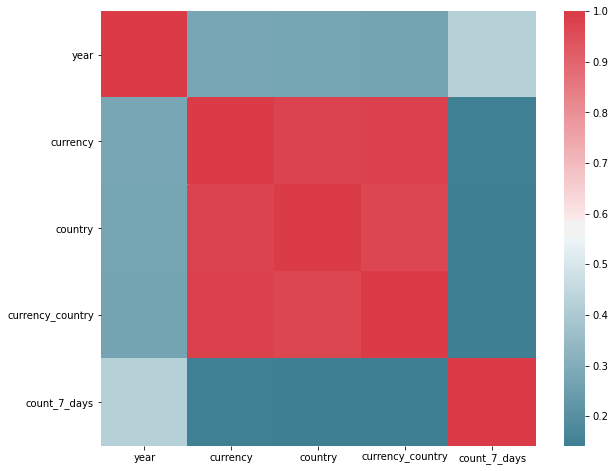

In [7]:
draw(valid[selected_columns])

## L1 regularization

Univariate methods consider only one feature at a time when making a selection decision. Instead, we can make our selection using all of the features by including them in a linear model with L1 regularization. This type of regularization (sometimes called Lasso) penalizes the absolute magnitude of the coefficients, as compared to L2 (Ridge) regression which penalizes the square of the coefficients.

As the strength of regularization is increased, features which are less important for predicting the target are set to 0. This allows us to perform feature selection by adjusting the regularization parameter. We choose the parameter by finding the best performance on a hold-out set, or decide ahead of time how many features to keep.

For **regression problems you can use sklearn.linear_model.Lasso**, or **sklearn.linear_model.LogisticRegression for classification**. These can be used along with sklearn.feature_selection.SelectFromModel to select the non-zero coefficients. Otherwise, the code is similar to the univariate tests.

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel

train, valid, _ = get_data_splits(baseline_data)

X, y = train[train.columns.drop("outcome")], train['outcome']

# Set the regularization parameter C=1
logistic = LogisticRegression(C=1, penalty="l2", random_state=7).fit(X, y)
model = SelectFromModel(logistic, prefit=True)

X_new = model.transform(X)
X_new

array([[1.200e+01, 1.100e+01, 8.000e+00, ..., 1.215e+03, 1.900e+03,
        1.800e+01],
       [4.000e+00, 2.000e+00, 9.000e+00, ..., 1.047e+03, 1.630e+03,
        3.100e+01],
       [0.000e+00, 1.200e+01, 1.000e+00, ..., 1.047e+03, 1.630e+03,
        3.100e+01],
       ...,
       [0.000e+00, 3.000e+00, 1.000e+01, ..., 1.172e+03, 1.830e+03,
        3.100e+01],
       [2.100e+01, 2.300e+01, 7.000e+00, ..., 6.650e+02, 1.036e+03,
        2.000e+00],
       [1.600e+01, 4.000e+00, 6.000e+00, ..., 5.930e+02, 9.200e+02,
        3.100e+01]])

Similar to the univariate tests, we get back an array with the selected features. Again, we will want to convert these to a DataFrame so we can get the selected columns.

In [9]:
# Get back the kept features as a DataFrame with dropped columns as all 0s
selected_features = pd.DataFrame(model.inverse_transform(X_new), 
                                 index=X.index,
                                 columns=X.columns)

# Dropped columns have values of all 0s, keep other columns 
selected_columns = selected_features.columns[selected_features.var() != 0]

In [10]:
# Get the valid dataset with the selected features.
valid[selected_columns].head()

,hour,day,month,country,category_currency,category_country,currency_country
302896,16,12,6,22,447,699,31
302897,1,8,7,22,617,958,31
302898,22,27,5,9,1018,1584,18
302899,5,29,7,22,1529,2386,31
302900,13,5,8,9,1735,2708,18


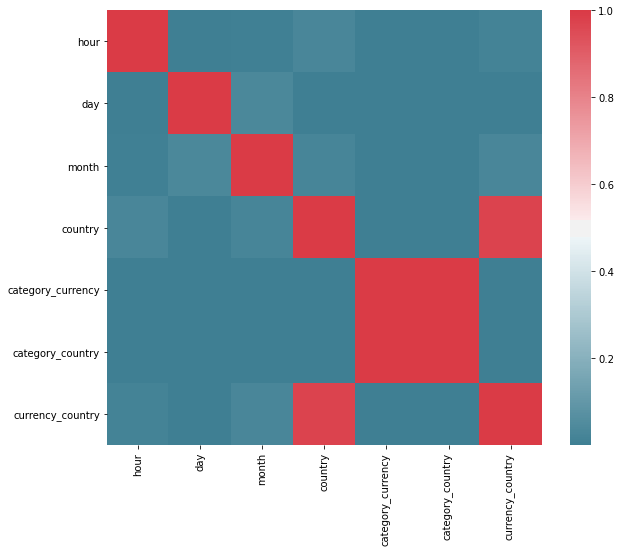

In [11]:
draw(valid[selected_columns])

In [15]:
valid[selected_columns].corr().abs().loc['category_country', 'category_currency']

hour                 0.000528
day                  0.000407
month                0.000190
country              0.003763
category_currency    0.999986
category_country     1.000000
currency_country     0.001635
Name: category_country, dtype: float64